# <h1>Time Series Analysis and Forecast on Irish Daily Covid Case Infection Rates</h1>

<h3>Nadia Abouelleil</h3>

<h2>Confirmed Covid Cases Forecast</h2>

- Importing libraries

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from datetime import datetime
import warnings
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm
warnings.filterwarnings('ignore')

- Reading data file
- Outputting the size

In [11]:
data=pd.read_csv("CovidCases.csv")
data.shape

(178, 2)

- Creating the 'Date' as a data index
- Printing the 1st 5 values of the dataset

In [12]:
data['Date']=pd.to_datetime(data['Date'], infer_datetime_format=True)
data=data.set_index(['Date'])

data.head()

,ConfirmedCovidCases
Date,
2020-02-29,1
2020-03-03,1
2020-03-04,4
2020-03-05,7
2020-03-06,5


- Plotting the Time Series graph of the Confirmed Covid Cases

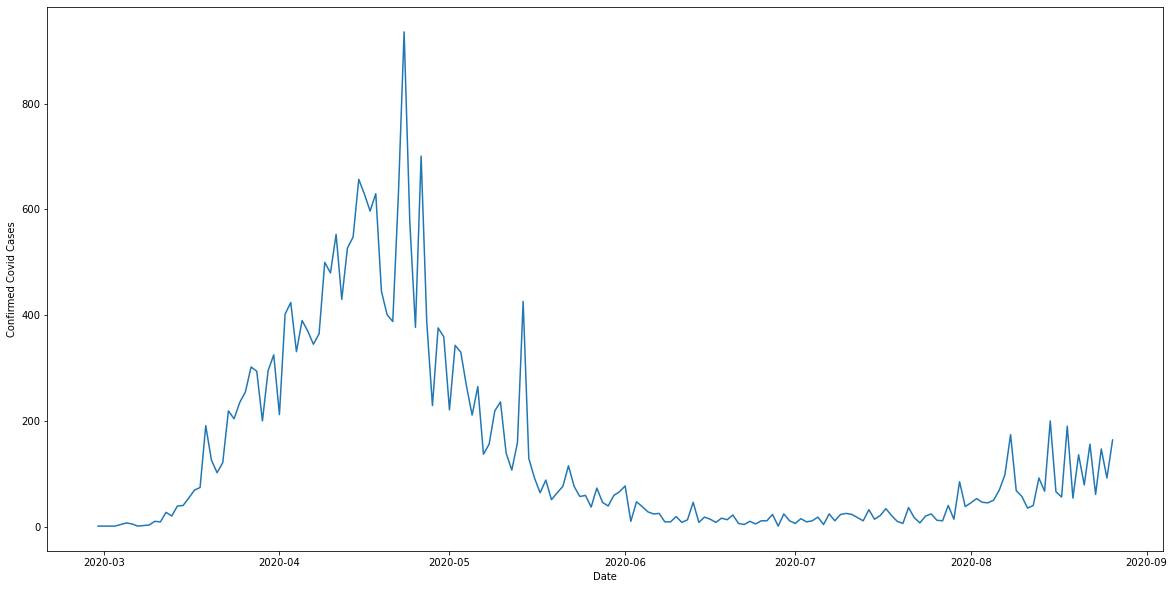

In [13]:
plt.figure(figsize=(20,10))
plt.xlabel("Date")
plt.ylabel("Confirmed Covid Cases")
plt.plot(data)

- Calculating the Rolling Mean and Standard Deviation of the Time Series so we can check it's stationarity 
- ** A Time Series is stationary if the mean and variance are constant

In [14]:
rolmean=data.rolling(window=12).mean()
rolstd=data.rolling(window=12).std()
print(rolmean.head(15))
print(rolstd.head(15))

            ConfirmedCovidCases
Date                           
2020-02-29                  NaN
2020-03-03                  NaN
2020-03-04                  NaN
2020-03-05                  NaN
2020-03-06                  NaN
2020-03-07                  NaN
2020-03-08                  NaN
2020-03-09                  NaN
2020-03-10                  NaN
2020-03-11                  NaN
2020-03-12                  NaN
2020-03-13             7.500000
2020-03-14            10.666667
2020-03-15            13.916667
2020-03-16            18.083333
            ConfirmedCovidCases
Date                           
2020-02-29                  NaN
2020-03-03                  NaN
2020-03-04                  NaN
2020-03-05                  NaN
2020-03-06                  NaN
2020-03-07                  NaN
2020-03-08                  NaN
2020-03-09                  NaN
2020-03-10                  NaN
2020-03-11                  NaN
2020-03-12                  NaN
2020-03-13             8.207535
2020-03-

- Plotting the Rolling Mean and Standard Deviation
- We can see the Time Series is non-stationary since the mean and variance are not constant

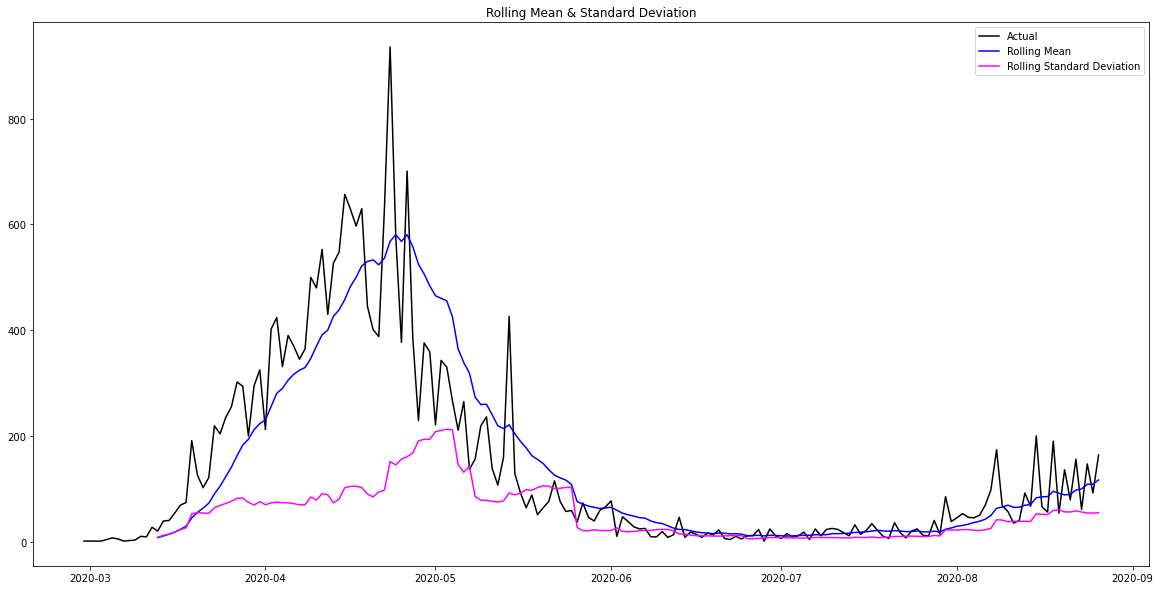

In [15]:
plt.figure(figsize=(20,10))
actual=plt.plot(data, color='black', label='Actual')
mean_6=plt.plot(rolmean, color='blue', label='Rolling Mean') 
std_6=plt.plot(rolstd, color='magenta', label='Rolling Standard Deviation')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

- Using the Dickey-Fuller (ADF) Test to also check stationarity
- Null hypothesis = Time series is nonstationary
- If ADF Statistic < Critical value then Reject Null Hypothesis

- Test Result: Non-Stationary

In [16]:
from statsmodels.tsa.stattools import adfuller
print('Dickey-Fuller Test: ')
dftest=adfuller(data['ConfirmedCovidCases'], autolag='AIC')
dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','P-value','Lags Used','No. of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Dickey-Fuller Test: 
Test Statistic               -2.519107
P-value                       0.110894
Lags Used                    14.000000
No. of Observations Used    163.000000
Critical Value (1%)          -3.471119
Critical Value (5%)          -2.879441
Critical Value (10%)         -2.576314
dtype: float64


- Making Time series stationary by logging the data
- Plotting the logged data

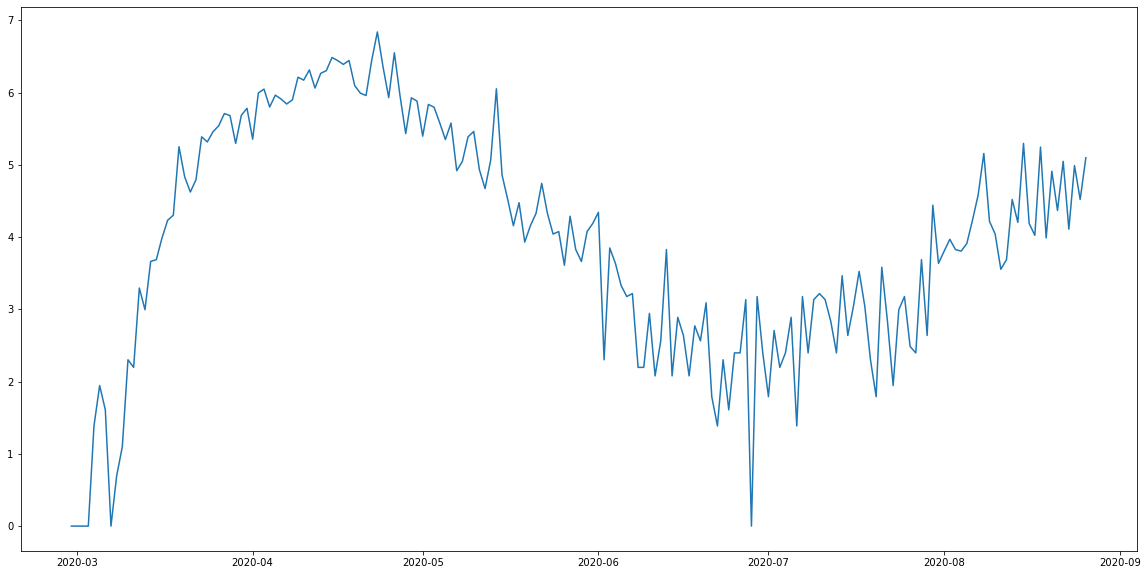

In [17]:
plt.figure(figsize=(20,10))
data_log=np.log(data)
plt.plot(data_log)

- Calculating Rolling Mean and Standard Deviation on logged time series to check stationarity
- Result: non-stationary

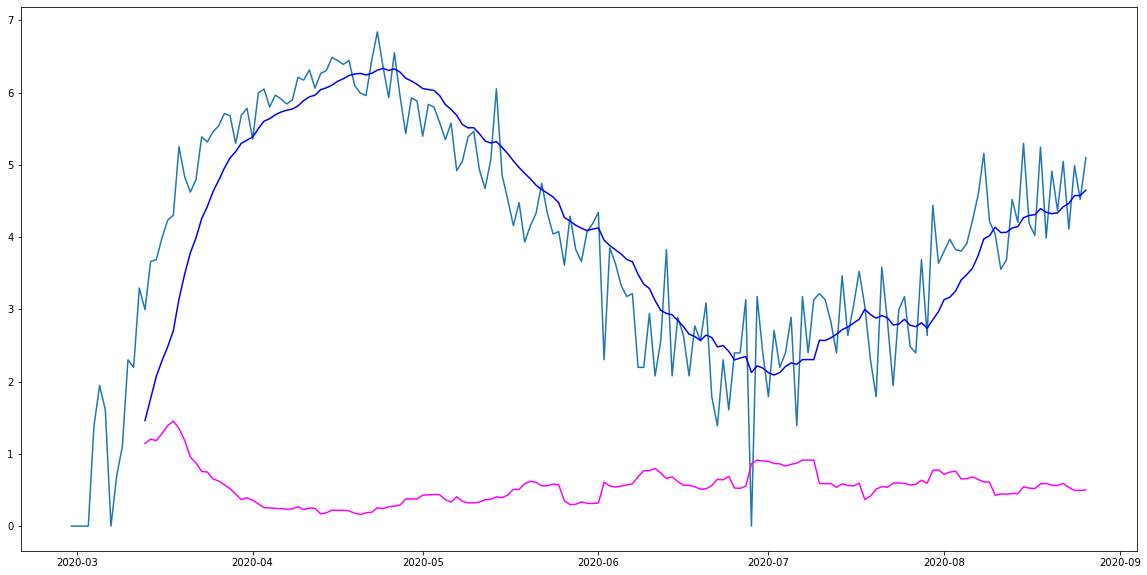

In [18]:
plt.figure(figsize=(20,10))
MAvg=data_log.rolling(window=12).mean()
MStd=data_log.rolling(window=12).std()
plt.plot(data_log)
plt.plot(MAvg, color='blue')
plt.plot(MStd, color='magenta')

- Making time series stationary using another differencing method

In [19]:
data_log_diff=data_log-MAvg
data_log_diff=data_log_diff.dropna()
data_log_diff.head()

,ConfirmedCovidCases
Date,
2020-03-13,1.535334
2020-03-14,1.897866
2020-03-15,1.615778
2020-03-16,1.698991
2020-03-17,1.753431


- Defining a function for the stationarity tests

In [20]:
def stationarity(timeseries):
    
    rolmean=timeseries.rolling(window=12).mean()
    rolstd=timeseries.rolling(window=12).std()
    
    plt.figure(figsize=(20,10))
    actual=plt.plot(timeseries, color='black', label='Actual')
    mean_6=plt.plot(rolmean, color='blue', label='Rolling Mean') 
    std_6=plt.plot(rolstd, color='magenta', label='Rolling Standard Deviation')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    print('Dickey-Fuller Test: ')
    dftest=adfuller(timeseries['ConfirmedCovidCases'], autolag='AIC')
    dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

- Checking the stationarity of differenced data
- Rolling method: Mean and standard deviation is somewhat varying
- ADF Method: Fail to reject null hypothesis (p-value > 0.5)
- Result: Our data should now be stationary

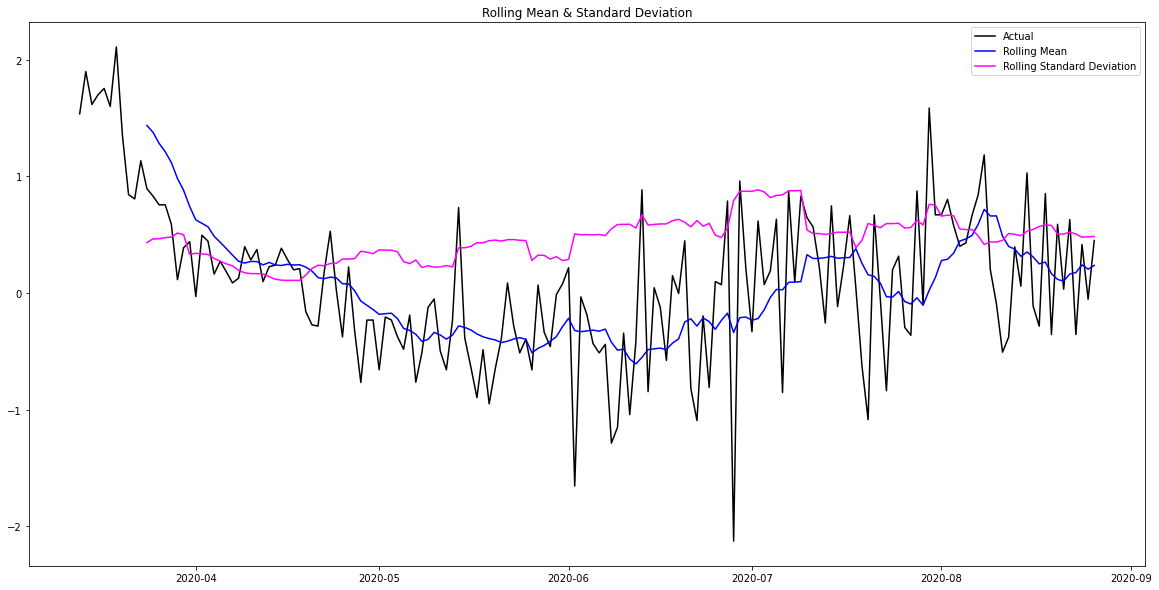

Dickey-Fuller Test: 
Test Statistic               -2.679143
p-value                       0.077718
Lags Used                    13.000000
No. of Observations Used    153.000000
Critical Value (1%)          -3.473830
Critical Value (5%)          -2.880623
Critical Value (10%)         -2.576945
dtype: float64


In [21]:
stationarity(data_log_diff)

- Checking for Trend stationarity
- Exponentially transforming the data

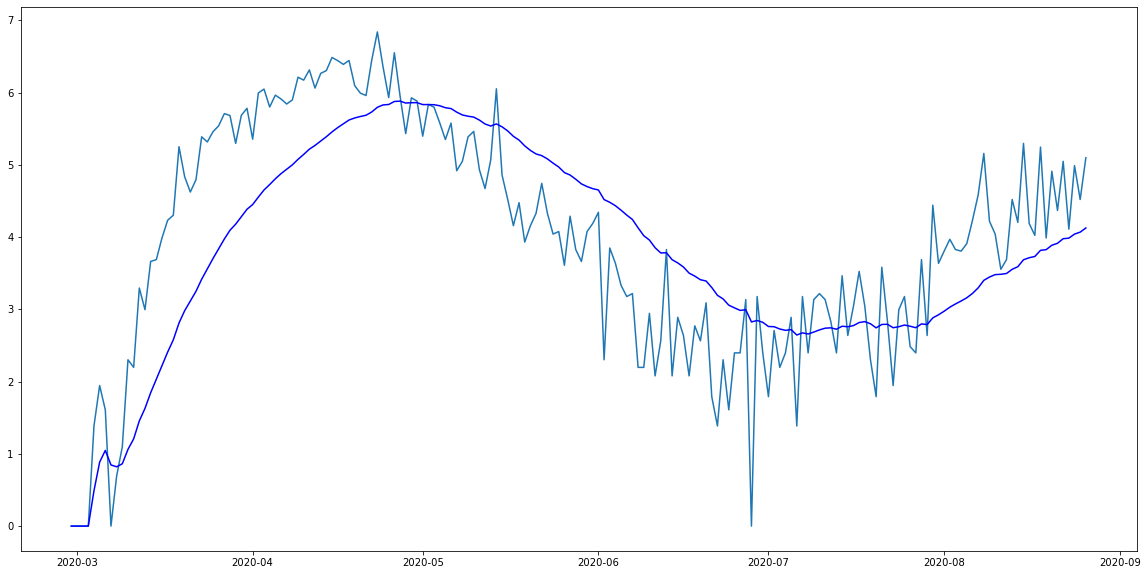

In [22]:
plt.figure(figsize=(20,10))
exp_data=data_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(data_log)
plt.plot(exp_data, color='blue')

- Differencing data to turn log transformation stationary

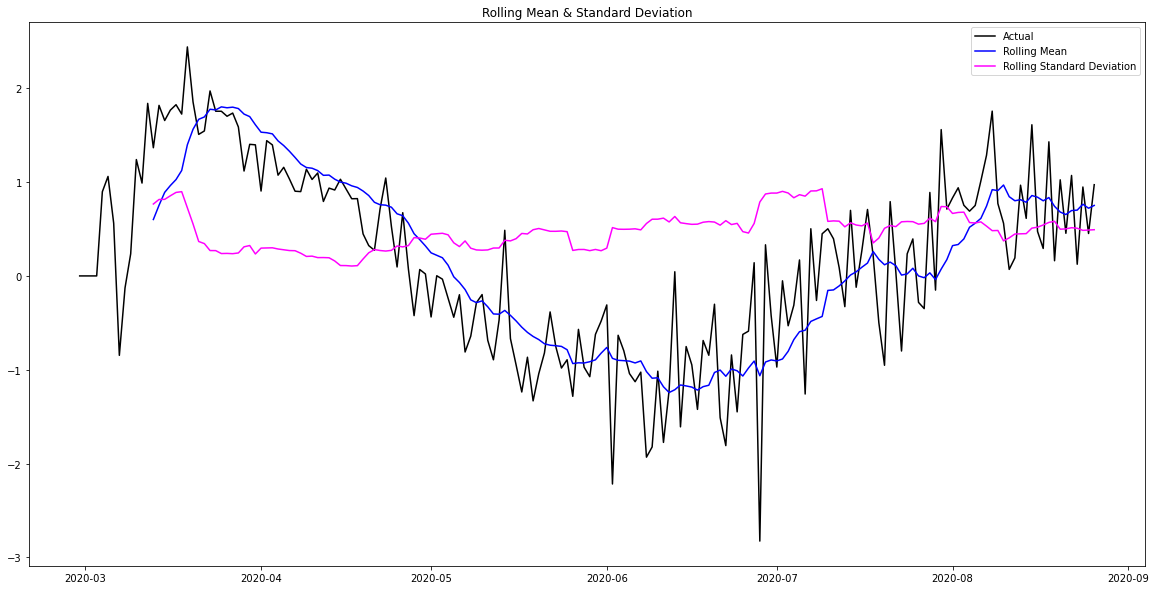

Dickey-Fuller Test: 
Test Statistic               -1.941153
p-value                       0.312956
Lags Used                    14.000000
No. of Observations Used    163.000000
Critical Value (1%)          -3.471119
Critical Value (5%)          -2.879441
Critical Value (10%)         -2.576314
dtype: float64


In [23]:
exp_data_diff=data_log-exp_data
stationarity(exp_data_diff)

- Shifting the values of the Time Series

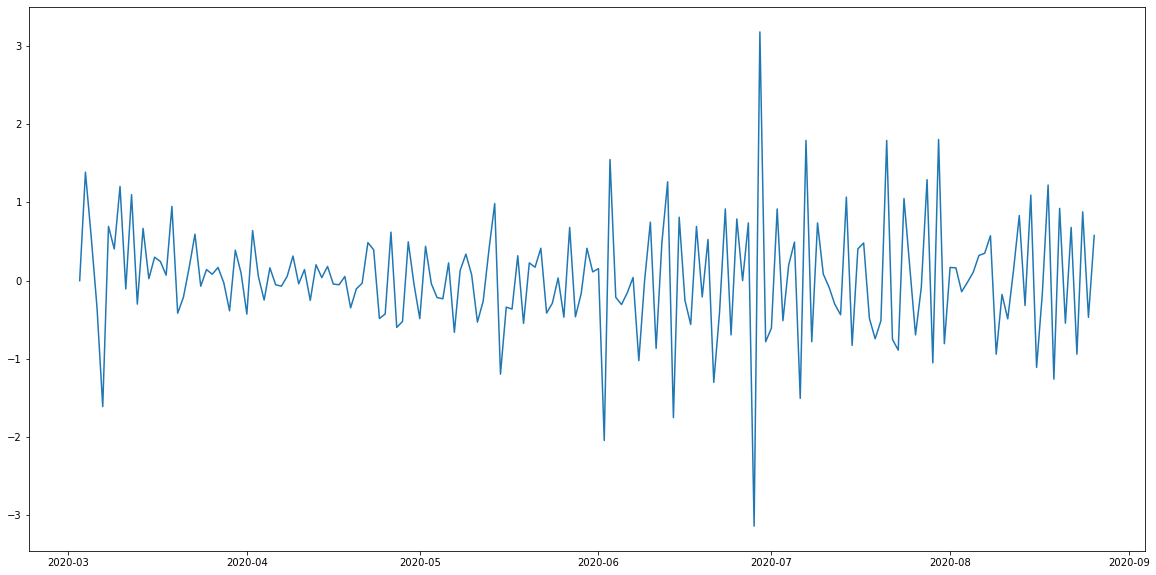

In [24]:
plt.figure(figsize=(20,10))
data_shift=data_log-data_log.shift()
plt.plot(data_shift)

- Dropping the NA values
- Testing stationarity
- Result: Time Series is Stationary

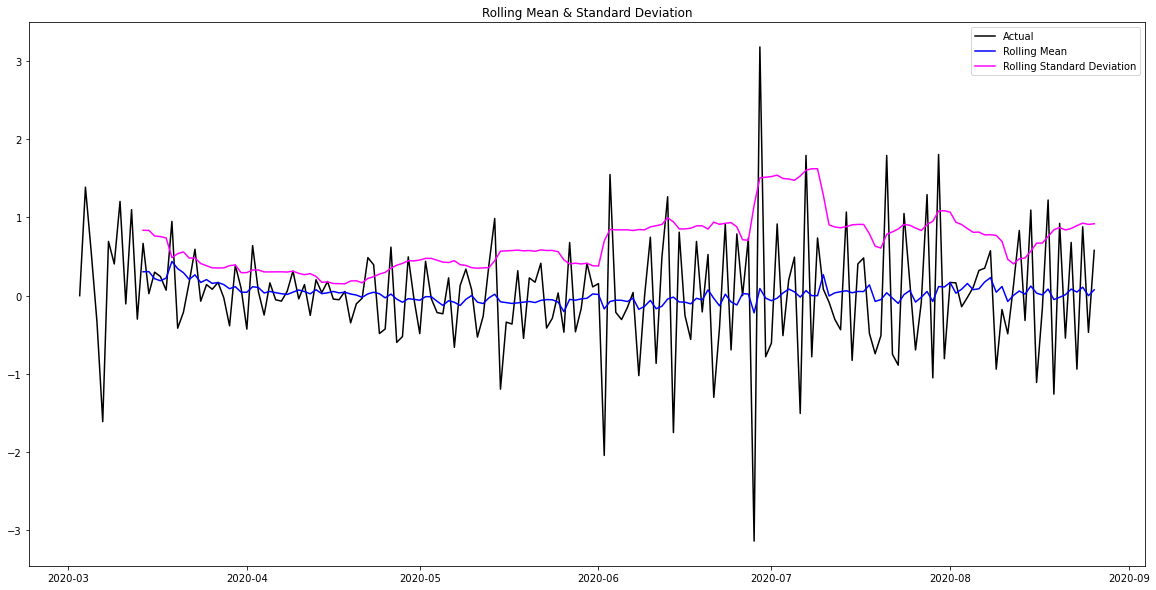

Dickey-Fuller Test: 
Test Statistic               -3.682191
p-value                       0.004371
Lags Used                    13.000000
No. of Observations Used    163.000000
Critical Value (1%)          -3.471119
Critical Value (5%)          -2.879441
Critical Value (10%)         -2.576314
dtype: float64


In [25]:
data_shift=data_shift.dropna()
stationarity(data_shift)

- Decomposing Time Series to see its Trend, Seasonality & Residual

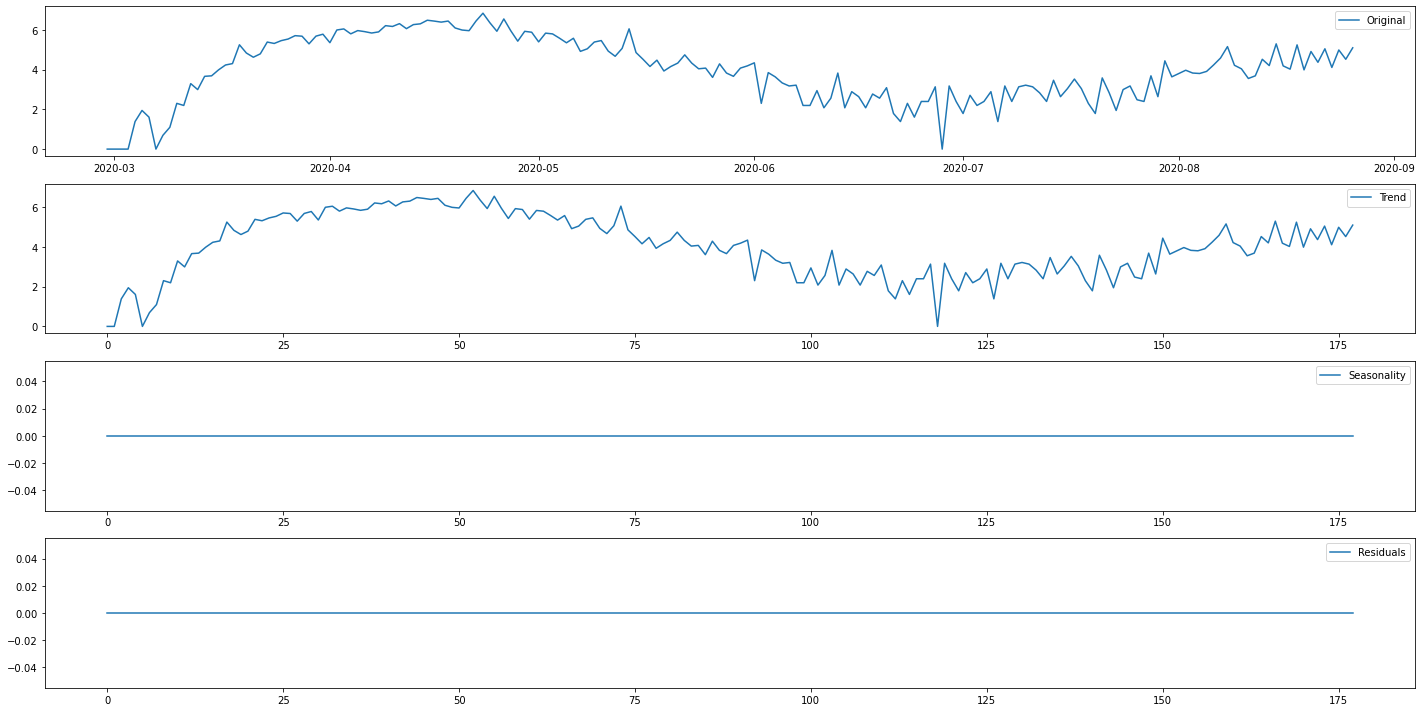

In [37]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp=seasonal_decompose(data_log.values, freq=1)

trend=decomp.trend
seasonal=decomp.seasonal
residual=decomp.resid

plt.subplot(411)
plt.plot(data_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

- Plotting ACF and PACF to find q and p value
- ACF = Auto-Correlation Function
- PACF = Partial Auto-Correlation Function

Text(0.5, 1.0, 'Autocorrelation Function')

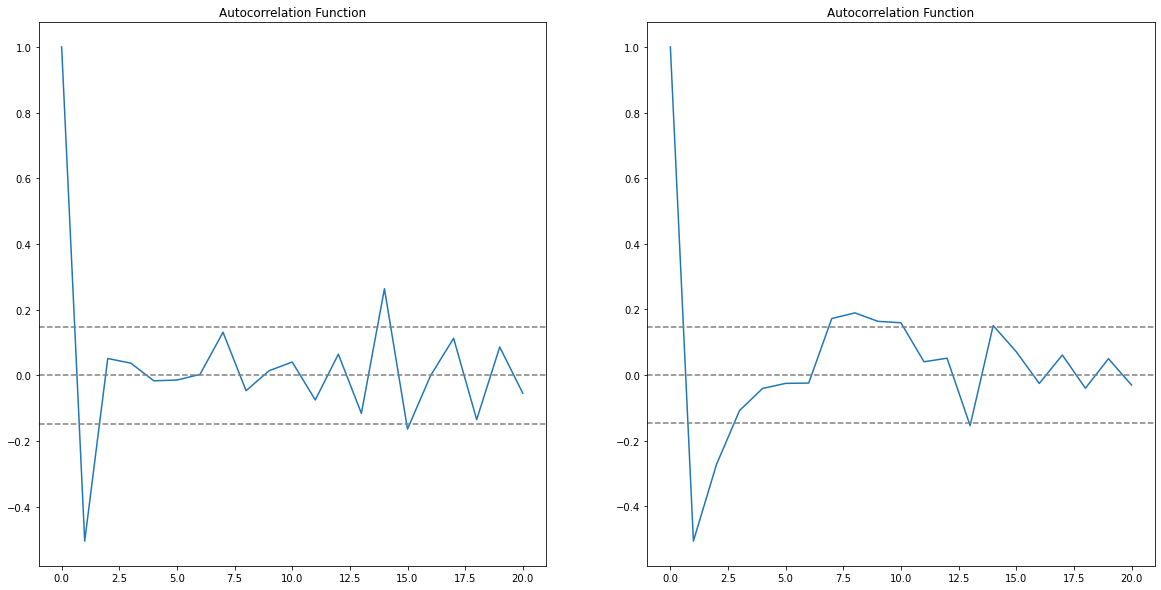

In [38]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf=acf(data_shift, nlags=20)
lag_pacf=pacf(data_shift, nlags=20, method='ols')

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='grey')
plt.axhline(y=-1.96/np.sqrt(len(data_shift)),linestyle='--',color='grey')
plt.axhline(y=1.96/np.sqrt(len(data_shift)),linestyle='--',color='grey')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='grey')
plt.axhline(y=-1.96/np.sqrt(len(data_shift)),linestyle='--',color='grey')
plt.axhline(y=1.96/np.sqrt(len(data_shift)),linestyle='--',color='grey')
plt.title('Autocorrelation Function')

- Creating ARIMA model with p=2, q=2 and I=1

plotting ARIMA model


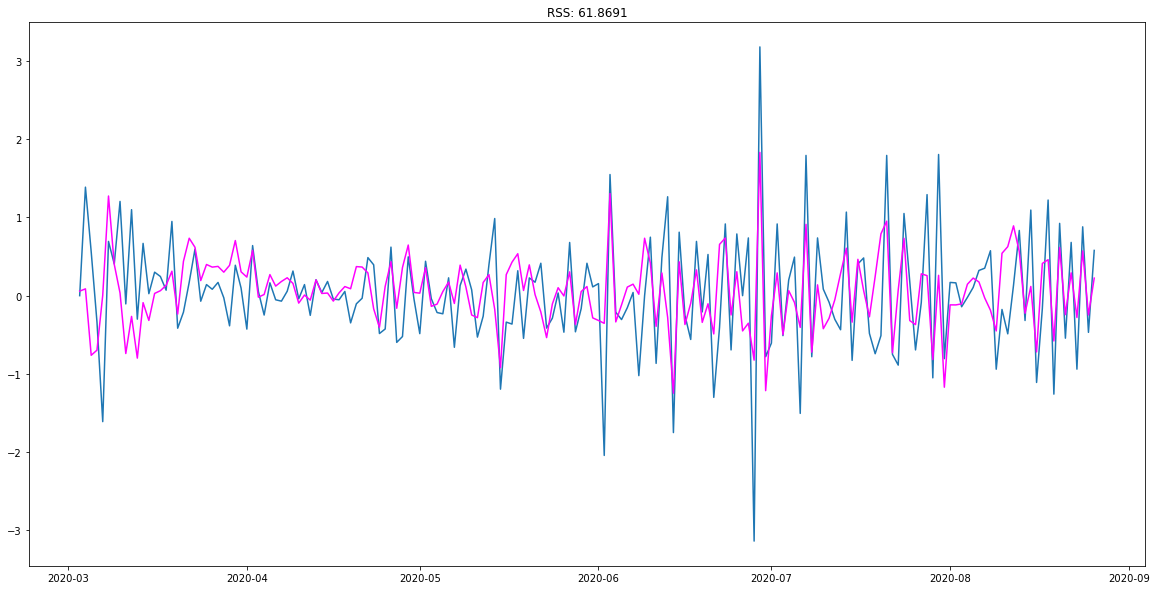

In [30]:
from statsmodels.tsa.arima_model import ARIMA

plt.figure(figsize=(20,10))
model=ARIMA(data_log, order=(2,1,2))
results=model.fit(disp=-1)
plt.plot(data_shift)
plt.plot(results.fittedvalues, color='magenta')
plt.title('RSS: %.4f'% sum((results.fittedvalues-data_shift['ConfirmedCovidCases'])**2))
print('plotting ARIMA model')

- Predicted values from ARIMA model in difference form

In [31]:
predictions=pd.Series(results.fittedvalues, copy=True)
print(predictions.head())

Date
2020-03-03    0.057911
2020-03-04    0.086850
2020-03-05   -0.761696
2020-03-06   -0.696024
2020-03-07    0.005936
dtype: float64


- Inverse Transformation for differencing using cumulative sum

In [32]:
predictions_cum_sum=predictions.cumsum()
print(predictions_cum_sum.head())

Date
2020-03-03    0.057911
2020-03-04    0.144761
2020-03-05   -0.616934
2020-03-06   -1.312958
2020-03-07   -1.307023
dtype: float64


- Predicted values in log scale

In [33]:
predictions_log=pd.Series(data_log['ConfirmedCovidCases'].iloc[0], index=data_log.index)
predictions_log=predictions_log.add(predictions_cum_sum,fill_value=0)
predictions_log.head()

predictions_log=pd.Series(data_log['ConfirmedCovidCases'].iloc[0], index=data_log.index)
predictions_log=predictions_log.add(predictions_cum_sum,fill_value=0)
predictions_log.head()

Date
2020-02-29    0.000000
2020-03-03    0.057911
2020-03-04    0.144761
2020-03-05   -0.616934
2020-03-06   -1.312958
dtype: float64

- Removing log transformation
- Plotting actual vs predicted value graph

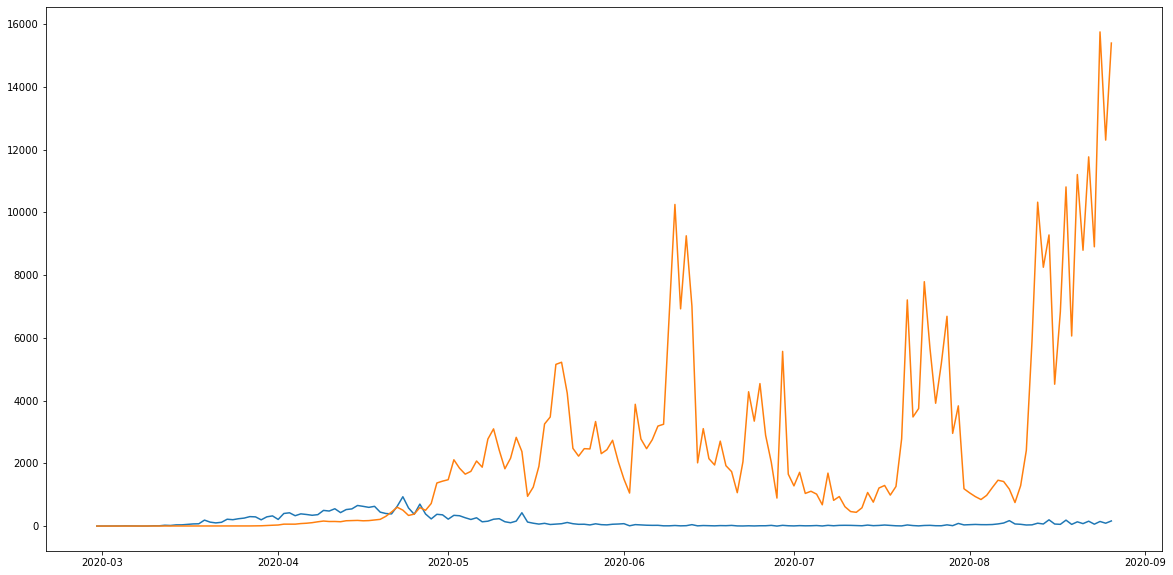

In [34]:
predictions_ARIMA=np.exp(predictions_log)
plt.figure(figsize=(20,10))
plt.plot(data)
plt.plot(predictions_ARIMA)

- Plotting the Time Series forecast of the next 4 months with 95% confidence interval

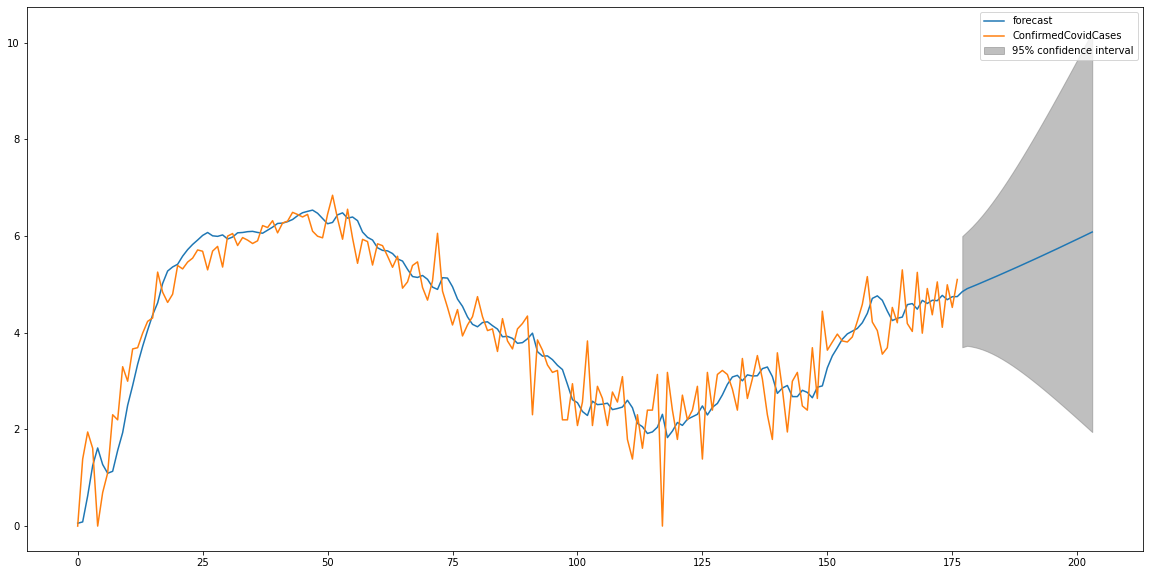

In [35]:
rcParams['figure.figsize']=20,10
results.plot_predict(1,204)
x=results.forecast(steps=120)

- Forecasted results in data form of the next 4 months

In [36]:
results.forecast(steps=120)

(array([ 4.84759362,  4.91061199,  4.95220386,  4.995702  ,  5.03947769,
         5.08363305,  5.12815047,  5.17302096,  5.21823515,  5.26378401,
         5.30965869,  5.35585063,  5.40235145,  5.44915302,  5.4962474 ,
         5.54362688,  5.59128395,  5.63921129,  5.68740177,  5.73584847,
         5.78454461,  5.83348365,  5.88265916,  5.93206491,  5.98169485,
         6.03154306,  6.08160378,  6.13187142,  6.18234052,  6.23300577,
         6.283862  ,  6.33490418,  6.38612741,  6.43752691,  6.48909804,
         6.54083628,  6.59273722,  6.64479657,  6.69701015,  6.74937391,
         6.80188389,  6.85453622,  6.90732716,  6.96025305,  7.01331034,
         7.06649557,  7.11980536,  7.17323642,  7.22678557,  7.28044969,
         7.33422575,  7.3881108 ,  7.44210197,  7.49619645,  7.55039153,
         7.60468456,  7.65907295,  7.71355419,  7.76812583,  7.8227855 ,
         7.87753086,  7.93235966,  7.98726971,  8.04225886,  8.09732502,
         8.15246617,  8.20768033,  8.26296557,  8.3